<a href="https://colab.research.google.com/github/ramy-arab/potato-disease-classification/blob/main/potato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Libraries and Set Constants

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

###Clone the Dataset Repository

In [ ]:
!git clone https://github.com/ramy-arab/potato-disease-classification.git


Cloning into 'potato-disease-classification'...
remote: Enumerating objects: 2161, done.
remote: Counting objects: 100% (2161/2161), done.
remote: Compressing objects: 100% (2160/2160), done.
remote: Total 2161 (delta 0), reused 2161 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2161/2161), 37.36 MiB | 39.94 MiB/s, done.


###Load Dataset and Display Class Names

In [18]:
# Dataset Loading
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/potato-disease-classification/dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Class Names
class_names = dataset.class_names
print("Class Names:", class_names)

Found 2152 files belonging to 3 classes.
Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


###4. Dataset Splitting

In [19]:
# Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = sum(1 for _ in ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

###Cell 4: Optimizing Performance with Prefetching

In [20]:
# Prefetching for Performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

###5. Data Augmentation Pipeline

In [22]:
# Data Augmentation using tf.image
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

###Cell 6: Squeeze-and-Excitation (SE) Block Definition

In [21]:
# Define Squeeze-and-Excitation Block
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

###Cell 7: Model Architecture with Attention Mechanism (SE Block

In [23]:
# Build Improved Model
def build_optimized_model():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    x = layers.Rescaling(1./255)(inputs)  # Normalize pixel values

    # First Block
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.3)(x)

    # Second Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.4)(x)

    # Third Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = squeeze_excite_block(x)
    x = layers.Dropout(0.4)(x)

    # Global Pooling and Dense Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(class_names), activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Compile Model
model = build_optimized_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 32)   │            896 │ rescaling_4[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ max_pooling2d_4[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 2)              │             66 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 32)             │             96 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 1, 32)       │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 128, 128, 32)   │              0 │ max_pooling2d_4[0][0], │
│                           │                        │                │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 128, 128, 32)   │              0 │ multiply_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ max_pooling2d_5[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)     

 Total params: 130,865 (511.19 KB)

 Trainable params: 130,417 (509.44 KB)

 Non-trainable params: 448 (1.75 KB)

###7. Train the Model

In [24]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('optimized_model.keras', save_best_only=True)

# Train the Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.7969 - loss: 0.5123 - val_accuracy: 0.4635 - val_loss: 1.2539 - learning_rate: 0.0010
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9378 - loss: 0.1572 - val_accuracy: 0.4688 - val_loss: 2.3919 - learning_rate: 0.0010
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9722 - loss: 0.0895 - val_accuracy: 0.5000 - val_loss: 3.7920 - learning_rate: 0.0010
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.9690 - loss: 0.0927 - val_accuracy: 0.4479 - val_loss: 5.0005 - learning_rate: 0.0010
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.9667 - loss: 0.0891 - val_accuracy: 0.3906 - val_loss: 5.3033 - learning_rate: 0.0010
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9688 - loss: 0.0709
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9688 - loss: 0.0709 - val_a

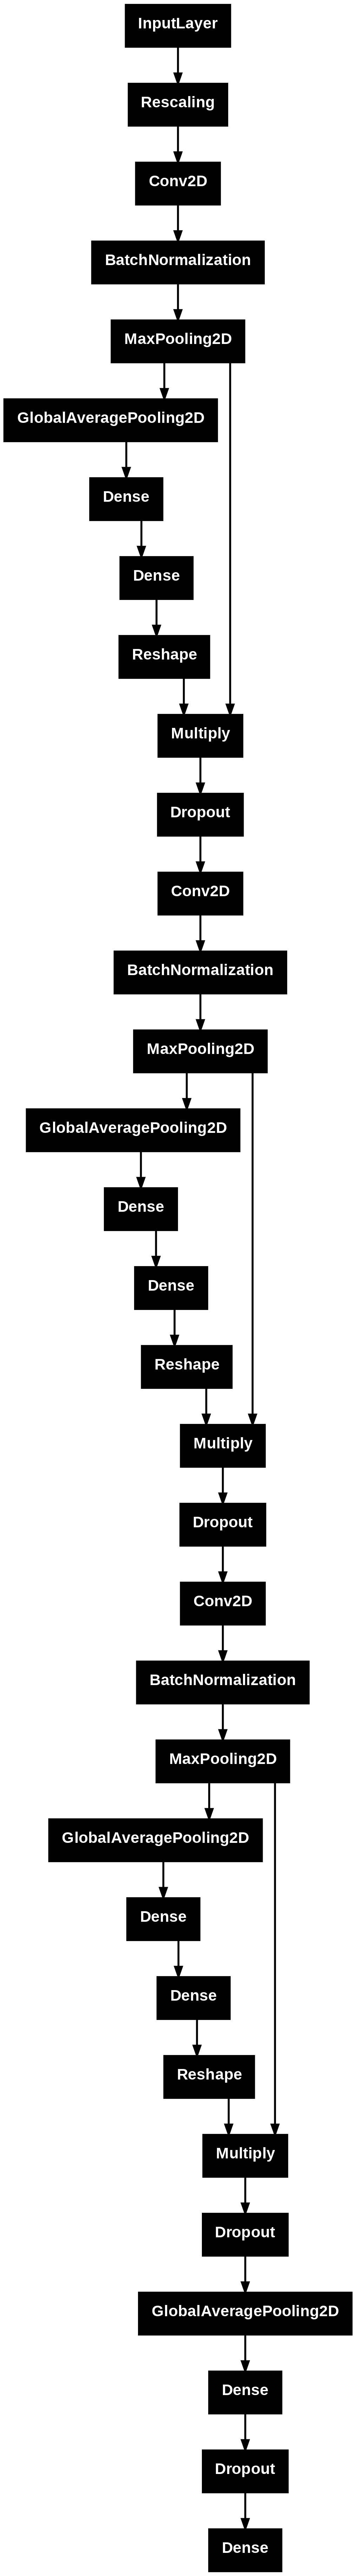

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model)


###8. Evaluate the Model on Test Data

In [25]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.9938 - loss: 0.0197
Test Accuracy: 99.14%


###9. Plot Training and Validation Accuracy

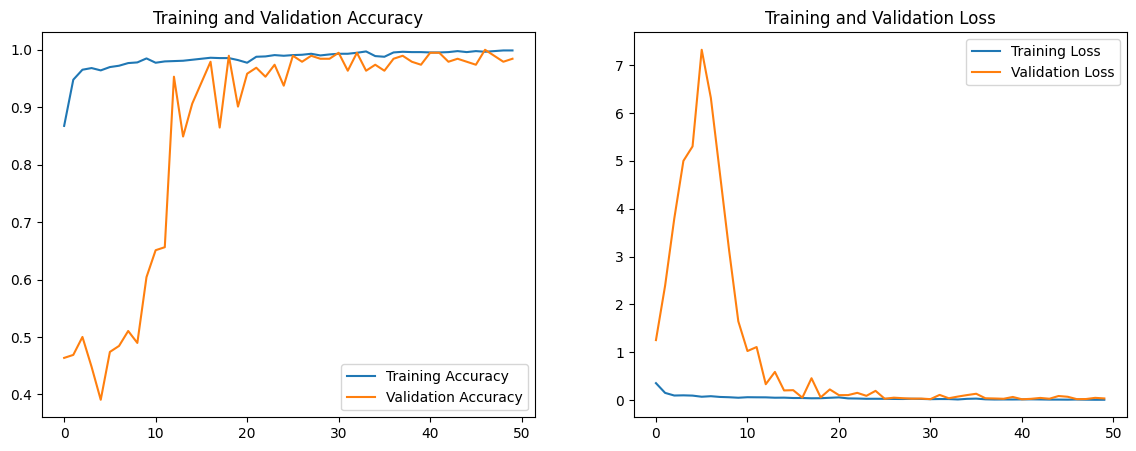

In [27]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_performance(history)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Prediction accuracy on test dataset: 0.47


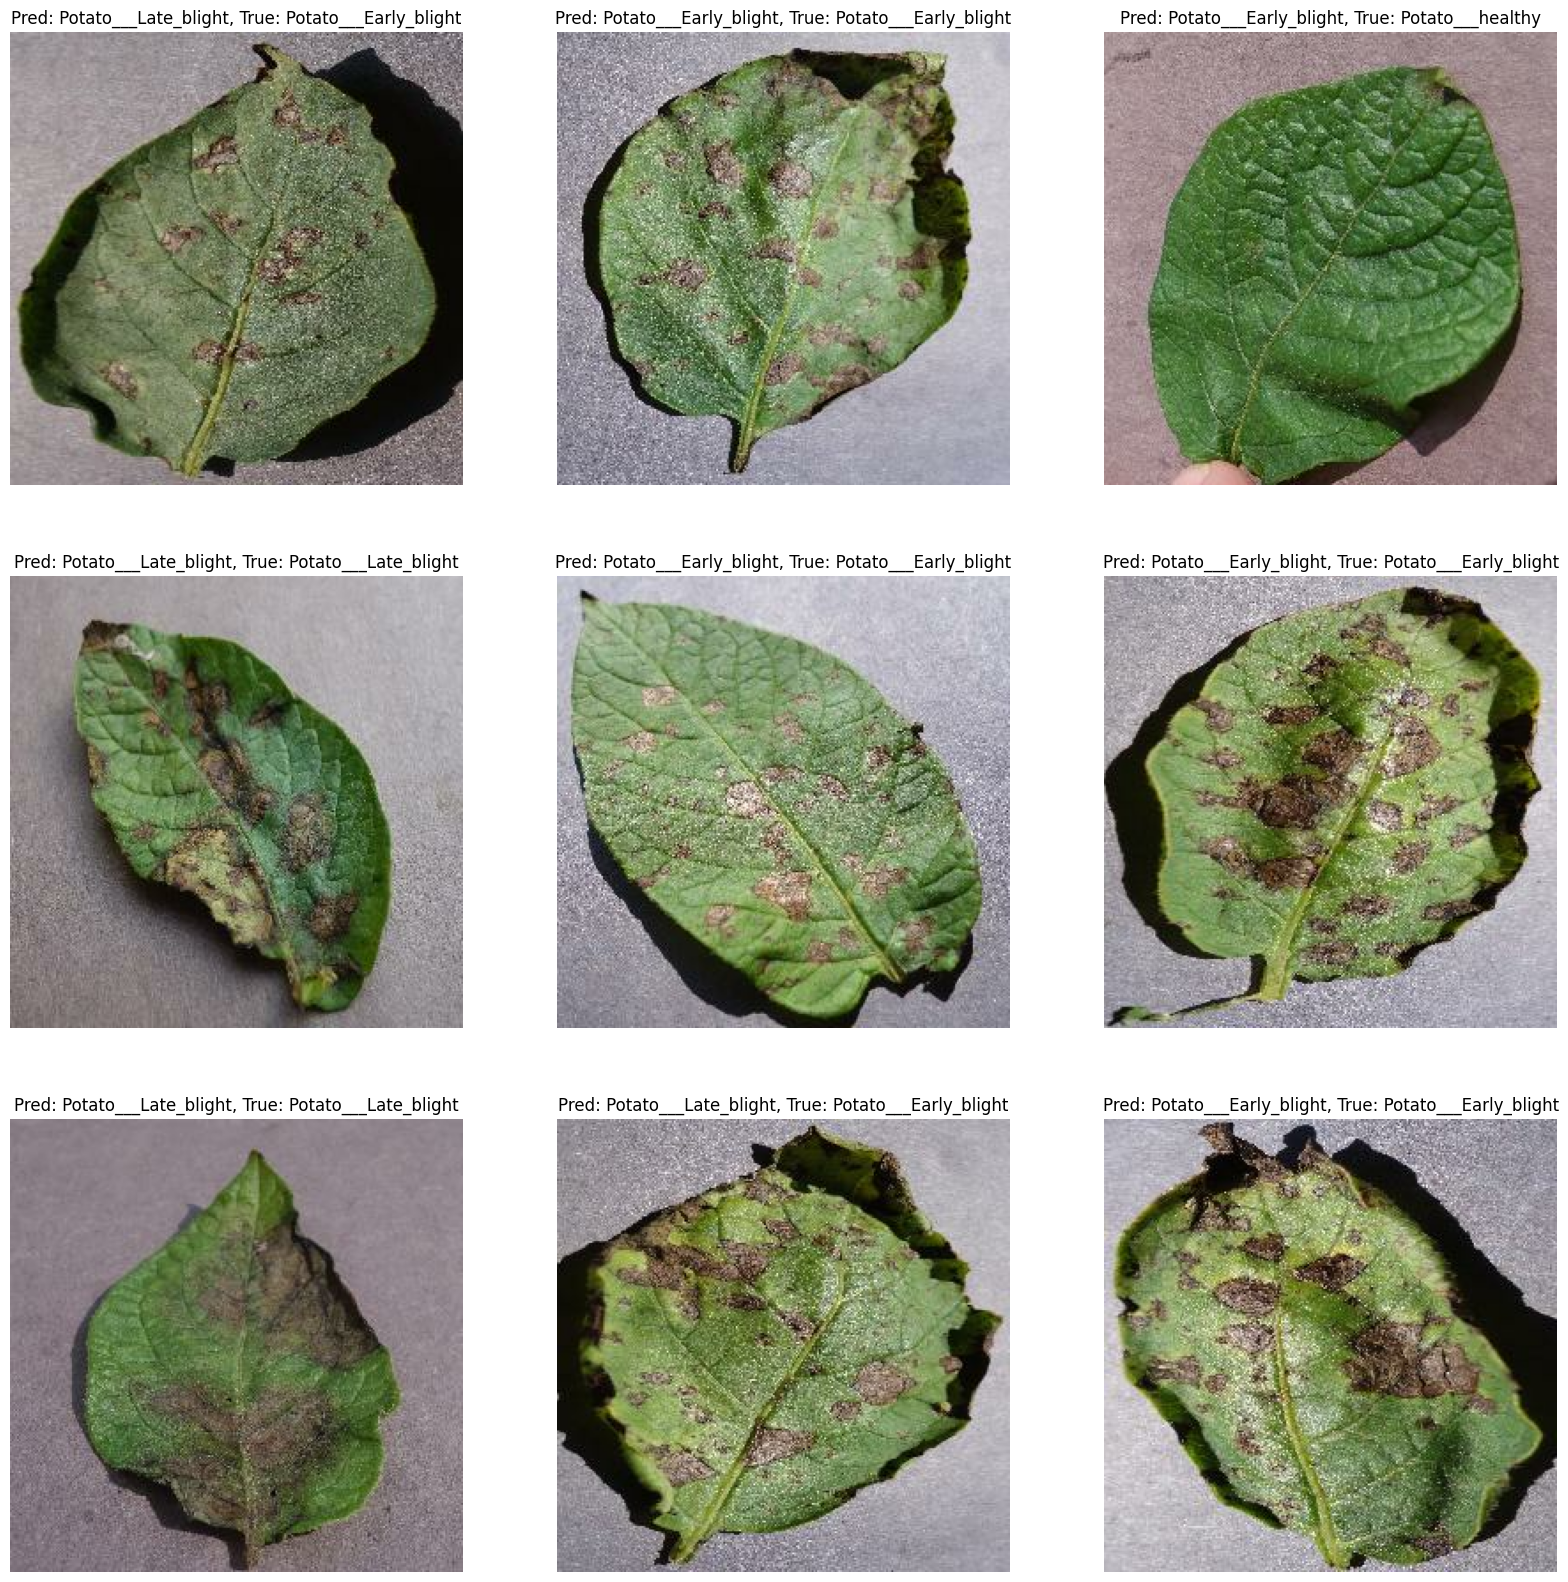

In [29]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Make predictions on the test dataset
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate accuracy
accuracy = np.sum(predicted_classes == true_labels) / len(true_labels)
print(f"Prediction accuracy on test dataset: {accuracy:.2f}")

# Display a few predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):  # Take one batch of test images
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_class = class_names[predicted_classes[i]]
        true_class = class_names[labels[i]]
        plt.title(f"Pred: {pred_class}, True: {true_class}")
        plt.axis("off")
plt.show()
